# Predicting the weekly return of a stock

## Import all necessary libraries

In [1]:
# pandas, pandas_datareader, numpy and matplotlib
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt

from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from pandas.plotting import scatter_matrix
from statsmodels.graphics.tsaplots import plot_acf

In [2]:
# Function and modules for the supervised regression models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

# Function and modules for data analysis and model evaluation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression

# Function and modules for deep learning models
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.layers import LSTM
from keras.wrappers.scikit_learn import KerasRegressor

# Function and modules for time series models
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

## Loading the data

In [3]:
# Stock tickers
stock_tickers = ['MSFT', 'IBM', 'GOOGL']

# Currency tickers from FRED (USD/JPY and GBP/USD)
ccy_tickers = ['DEXJPUS', 'DEXUSUK']

# Indices tickers from FRED (S&P500, Dow Jones Industrial Avg and VIX)
indices_tickers = ['SP500', 'DJIA', 'VIXCLS']

stock_data = web.DataReader(stock_tickers, 'yahoo')
ccy_data = web.DataReader(ccy_tickers, 'fred')
indices_data = web.DataReader(indices_tickers, 'fred')

In [4]:
stock_data.head()

Attributes  Adj Close                             Close              \
Symbols          MSFT         IBM      GOOGL       MSFT         IBM   
Date                                                                  
2017-08-21  67.795723  105.766693  46.043499  72.150002  134.158707   
2017-08-22  68.744766  106.279182  47.020000  73.160004  134.808792   
2017-08-23  68.331329  107.130859  47.129002  72.720001  135.889099   
2017-08-24  68.303131  107.733826  46.844501  72.690002  136.653915   
2017-08-25  68.425285  108.336769  46.525002  72.820000  137.418732   

Attributes                  High                               Low  \
Symbols         GOOGL       MSFT         IBM      GOOGL       MSFT   
Date                                                                 
2017-08-21  46.043499  72.480003  134.244736  46.412498  71.699997   
2017-08-22  47.020000  73.239998  134.942642  47.098000  72.349998   
2017-08-23  47.129002  73.150002  136.759079  47.271500  72.529999   
2017-08-24  46.844501  72.860001  137.361374  47.315498  72.070000   
2017-08-25  46.525002  73.349998  137.848953  47.036499  72.480003   

Attributes                              Open                         \
Symbols            IBM      GOOGL       MSFT         IBM      GOOGL   
Date                                                                  
2017-08-21  133.011475  45.930000  72.470001  133.451248  46.288502   
2017-08-22  134.206497  46.308498  72.349998  134.455063  46.348000   
2017-08-23  134.493301  46.762001  72.959999  134.512421  46.849998   
2017-08-24  135.994263  46.536999  72.739998  136.233276  47.185501   
2017-08-25  136.950287  46.505001  72.860001  136.998093  46.960499   

Attributes      Volume                         
Symbols           MSFT        IBM       GOOGL  
Date                                           
2017-08-21  17734800.0  3337472.0  26024000.0  
2017-08-22  14343700.0  2661442.0  35502000.0  
2017-08-23  13766500.0  4234522.0  22690000.0  
2017-08-24  17098300.0  3757441.0  25892000.0  
2017-08-25  12794300.0  3005053.0  23746000.0

In [5]:
ccy_data.head()

,DEXJPUS,DEXUSUK
DATE,,
2017-08-22,109.40,1.2834
2017-08-23,109.14,1.2787
2017-08-24,109.34,1.2802
2017-08-25,109.24,1.2873
2017-08-28,109.22,1.2927


In [6]:
indices_data.head()

,SP500,DJIA,VIXCLS
DATE,,,
2017-08-22,2452.51,21899.89,11.35
2017-08-23,2444.04,21812.09,12.25
2017-08-24,2438.97,21783.40,12.23
2017-08-25,2443.05,21813.67,11.28
2017-08-28,2444.24,21808.40,11.32


In [7]:
print(stock_data.shape)
print(ccy_data.shape)
print(indices_data.shape)

(1259, 18)
(1299, 2)
(1304, 3)


We get about 5 years worth of individual stock price, currency and indices prices data to work with.

## Define x and y variables
- y variable is the weekly return of the stock (in this case Microsoft)
- Number of trading days assumed to be five
- Independent or x variables:
    - Use correlated assets (currencies and indices) and historical returns of stock
    - Lagged five days return of stocks, currencies and indices
    - Lagged 5-day, 15-day, 30-day and 60-day of stock

In [8]:
# Define number of trading days
return_period = 5

# Set the y variable
# We will take the log of the Adjusted Close, then find the discrete difference over a 5-day period
# We then shift this 5-day difference back by 5 trading days
y = np.log(stock_data.loc[:, ('Adj Close', 'MSFT')]).diff(return_period).shift(-return_period)

# Rename the variable with "stock_ticker" & "pred" from the MultiIndex of Attribute & Symbols
y.name = y.name[-1] + '_pred'

In [9]:
y.head()

Date
2017-08-21    0.009381
2017-08-22   -0.001504
2017-08-23    0.017584
2017-08-24    0.028213
2017-08-25    0.015264
Name: MSFT_pred, dtype: float64

In [10]:
# Log stock prices, then find the 5-day return
# Drop level to change from Multi Index to single index
x1 = np.log(stock_data.loc[:, ('Adj Close', ('GOOGL', 'IBM'))]).diff(return_period)
x1.columns = x1.columns.droplevel()

# Log currency rates, then find the 5-day return
x2 = np.log(ccy_data).diff(return_period)

# Log indices level, then find the 5-day return
x3 = np.log(indices_data).diff(return_period)

# Find the 5-day, 15-day, 30-day and 60-day returns of MSFT stock
# Concat on the columns, then drop all the null rows
x4 = pd.concat([np.log(stock_data.loc[:, ('Adj Close', 'MSFT')]).\
                diff(i) for i in [return_period, return_period*3, return_period*6, return_period*12]],\
               axis=1).dropna()

# Rename the columns according to the return period
x4.columns = ['MSFT_DT', 'MSFT_3DT', 'MSFT_6DT', 'MSFT_12DT']

In [11]:
# Concat all the previous dataframes into one along columns axis
X = pd.concat([x1, x2, x3, x4], axis=1)

# Join y and x together into a single dataframe, drop null rows
# Slice df in intervals of 5 to get the weekly returns
df = pd.concat([y, X], axis=1).dropna().iloc[::return_period, :]

In [12]:
# Final dataset of weekly stock returns
df.head()

,MSFT_pred,GOOGL,IBM,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT
2017-11-14,0.001075,-0.010267,-0.006442,-0.003518,-0.001826,-0.004554,-0.006292,0.158619,-0.002614,0.063738,0.123839,0.152665
2017-11-22,0.012673,0.014854,0.031254,-0.013614,0.009525,0.012577,0.010894,-0.284387,0.001565,0.004168,0.088930,0.134030
2017-12-01,-0.001188,-0.030220,0.019048,0.003044,0.012593,0.015178,0.028192,0.167213,0.011939,0.007029,0.083363,0.130268
2017-12-08,0.031462,0.023439,0.000323,0.014816,-0.010271,0.003506,0.004018,-0.176564,-0.001188,0.011473,0.071324,0.123313
2017-12-15,-0.015549,0.021326,-0.015034,-0.007691,-0.003823,0.009127,0.013172,-0.016843,0.031462,0.042214,0.037780,0.162293


In [13]:
# Separate into X and y variables
y = df.loc[:, y.name]
X = df.loc[:, X.columns]

## EDA: Exploratory Data Analysis

In [14]:
df.isnull().sum()

MSFT_pred    0
GOOGL        0
IBM          0
DEXJPUS      0
DEXUSUK      0
SP500        0
DJIA         0
VIXCLS       0
MSFT_DT      0
MSFT_3DT     0
MSFT_6DT     0
MSFT_12DT    0
dtype: int64

In [15]:
df.describe()

,MSFT_pred,GOOGL,IBM,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT
count,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000,225.000000
mean,0.005181,0.002717,0.001536,0.000869,-0.000402,0.002148,0.001661,0.002061,0.005095,0.015471,0.030875,0.066923
std,0.035068,0.038041,0.039974,0.011082,0.013804,0.028579,0.029603,0.166341,0.033718,0.058523,0.070269,0.093607
min,-0.137317,-0.131259,-0.173145,-0.052258,-0.066158,-0.140676,-0.166713,-0.401002,-0.137317,-0.239569,-0.299102,-0.180214
25%,-0.015549,-0.020716,-0.014824,-0.005191,-0.007614,-0.010028,-0.011250,-0.108302,-0.013520,-0.014448,-0.004215,0.014550
50%,0.007575,0.006889,0.004379,0.000756,-0.000960,0.005695,0.004018,-0.017003,0.007820,0.021046,0.039437,0.087884
75%,0.026374,0.025037,0.023349,0.006562,0.006834,0.016271,0.016885,0.088505,0.024913,0.048122,0.076708,0.130268
max,0.164103,0.096339,0.175315,0.052731,0.075400,0.160395,0.183091,0.650554,0.164103,0.244822,0.207462,0.293344


### Visualisation using a correlation heatmap

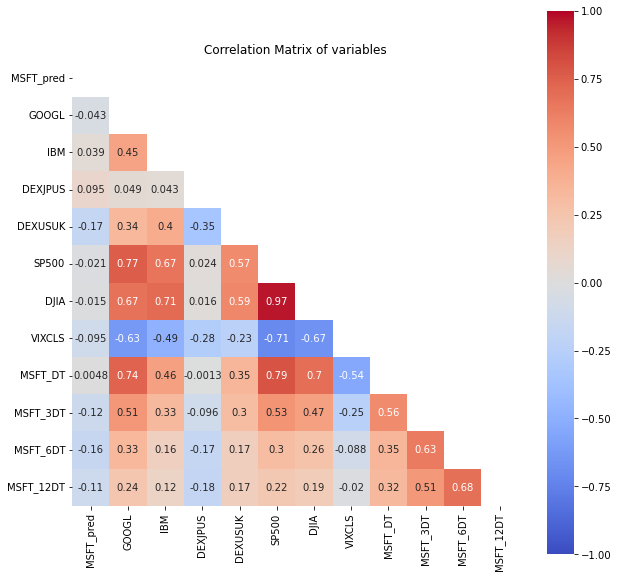

In [16]:
# Find the correlation between the variables
df_corr = df.corr()

# Masking the plot
mask = np.zeros_like(df_corr)
mask[np.triu_indices_from(mask)]=True

# Plot the heatmap
plt.figure(figsize=(10,10))
plt.title('Correlation Matrix of variables')
sns.heatmap(df_corr, vmax=1, vmin=-1, square=True, annot=True, cmap='coolwarm', mask=mask);

There seems to be some correlation of the predicted variable with the lagged 5 days, 15 days, 30 days and 60 days return of the stock.

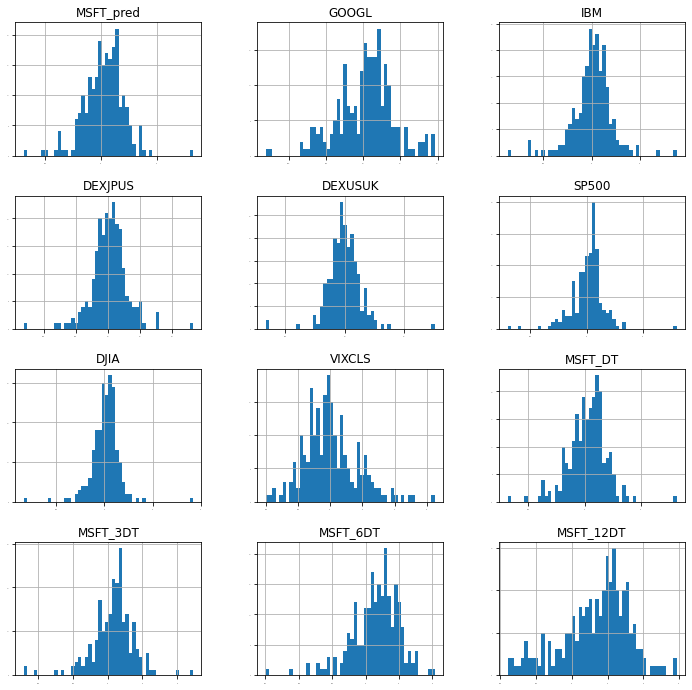

In [17]:
# distribution of each series individually
df.hist(bins=50, sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
plt.show();

<Figure size 1080x1080 with 0 Axes>

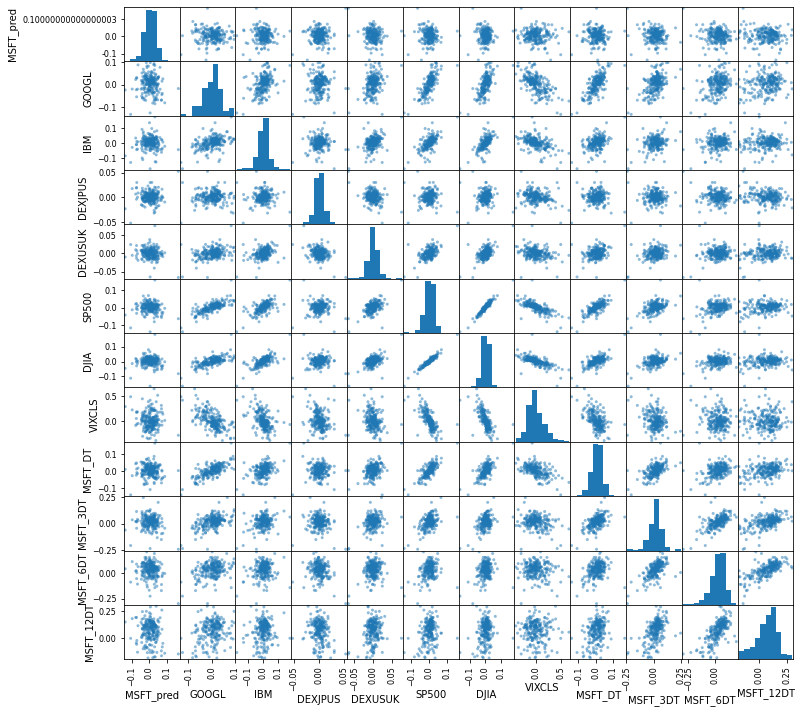

In [18]:
plt.figure(figsize=(15,15))
scatter_matrix(df,figsize=(12,12))
plt.show();

There seems to be some sort of linear relationship between the predicted variable and the lagged returns.

## Time series analysis

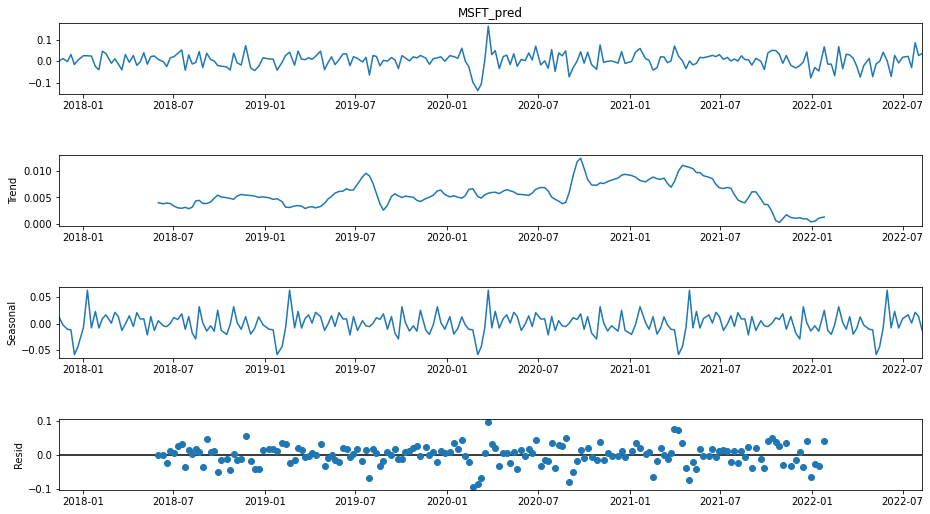

In [19]:
res = sm.tsa.seasonal_decompose(y,period=52)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show();

We can see that for MSFT there has been a general trend downwards. This should show up in our constant/bias terms in our models.

## Feature Selection
- We use sklearn's SelectKBest function to get a sense of feature importance.

In [20]:
bestfeatures = SelectKBest(k=5, score_func=f_regression)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
featureScores.nlargest(10,'Score').set_index('Specs')  #print 10 best features

,Score
Specs,
DEXUSUK,6.557240
MSFT_6DT,5.760448
MSFT_3DT,3.185845
MSFT_12DT,2.859753
VIXCLS,2.046321
DEXJPUS,2.012596
GOOGL,0.408671
IBM,0.345826
SP500,0.097250


We see that the 30 days lagged return is the most important feature, while the DJIA is the least important.

## Train-test split

In [21]:
validation_size = 0.2

# In case the data is not dependent on the time series, then train and test split randomly
# seed = 42
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=validation_size, random_state=seed)

# In case the data is not dependent on the time series, then train and test split should be done based on sequential sample
# This can be done by selecting an arbitrary split point in the ordered list of observations and creating two new datasets.
train_size = int(len(X) * (1-validation_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]
y_train, y_test = y[0:train_size], y[train_size:len(X)]

In [22]:
num_folds = 10
seed = 42
# scikit is moving away from mean_squared_error. 
# In order to avoid confusion, and to allow comparison with other models, we invert the final scores
scoring = 'neg_mean_squared_error' 

## Models

In [23]:
# Regression and tree regression algorithms
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))

In [24]:
# Neural network algorithms
models.append(('MLP', MLPRegressor()))

In [25]:
# Ensemble models algorithms

# Boosting methods
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))

# Bagging methods
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))

Once we have selected all the models, we loop over each of them. 
1. First we run the K-fold analysis. 
2. Next we run the model on the entire training and testing dataset

In [26]:
names = []
kfold_results = []
test_results = []
train_results = []

for name, model in models:
    names.append(name)
    
    ## K Fold analysis:
    
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)

    # Converted mean square error to positive. The lower the better
    cv_results = -1* cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)
    
    # Full Training period
    res = model.fit(X_train, y_train)
    train_result = mean_squared_error(res.predict(X_train), y_train)
    train_results.append(train_result)
    
    # Test results
    test_result = mean_squared_error(res.predict(X_test), y_test)
    test_results.append(test_result)
    
    msg = "%s: %f (%f) %f %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
    print(msg)

LR: 0.001231 (0.000382) 0.000960 0.001960
LASSO: 0.001146 (0.000451) 0.001123 0.001637
EN: 0.001146 (0.000451) 0.001123 0.001637
KNN: 0.001509 (0.000480) 0.000980 0.001788
CART: 0.002880 (0.001538) 0.000000 0.003562
SVR: 0.001426 (0.001126) 0.001038 0.001681
MLP: 0.002139 (0.001387) 0.001308 0.001842
ABR: 0.001333 (0.000562) 0.000603 0.001880
GBR: 0.001653 (0.000754) 0.000100 0.001862
RFR: 0.001383 (0.000631) 0.000192 0.001698
ETR: 0.001404 (0.000462) 0.000000 0.001700


### K-fold results

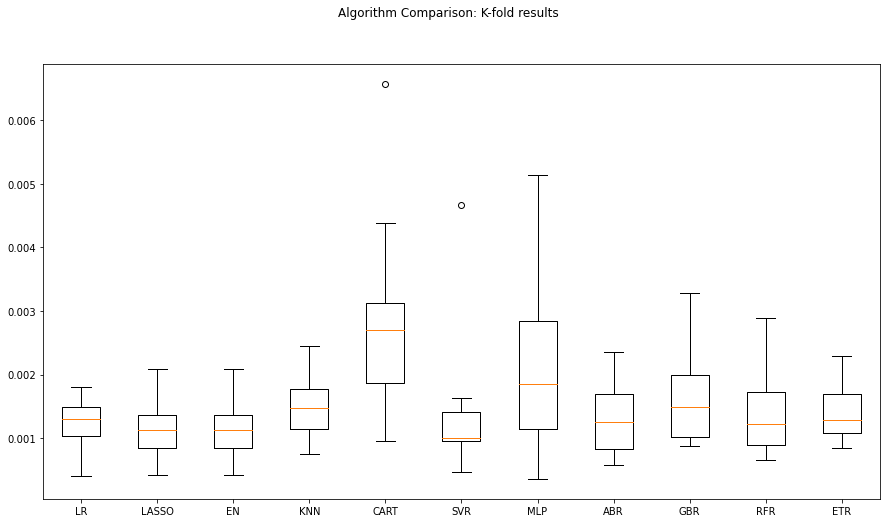

In [27]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison: K-fold results')
ax = fig.add_subplot(111)
plt.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
plt.show();

## Training and Test error

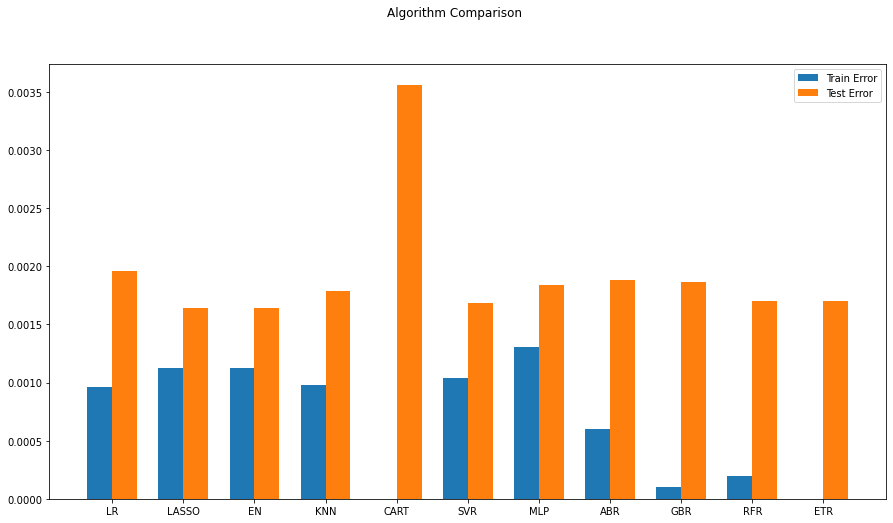

In [28]:
# compare algorithms
fig = plt.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.bar(ind - width/2, train_results,  width=width, label='Train Error')
plt.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
plt.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
plt.show()

## Time series ARIMA model

In [29]:
X_train_ARIMA=X_train.loc[:, ['GOOGL', 'IBM', 'DEXJPUS', 'SP500', 'DJIA', 'VIXCLS']]
X_test_ARIMA=X_test.loc[:, ['GOOGL', 'IBM', 'DEXJPUS', 'SP500', 'DJIA', 'VIXCLS']]
tr_len = len(X_train_ARIMA)
te_len = len(X_test_ARIMA)
to_len = len (X)

In [31]:
modelARIMA=ARIMA(endog=y_train,exog=X_train_ARIMA,order=[1,0,0])
model_fit = modelARIMA.fit()

C:\Users\finan\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\finan\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency

In [32]:
error_Training_ARIMA = mean_squared_error(y_train, model_fit.fittedvalues)
predicted = model_fit.predict(start = tr_len -1 ,end = to_len -1, exog = X_test_ARIMA)[1:]
error_Test_ARIMA = mean_squared_error(y_test,predicted)
error_Test_ARIMA

C:\Users\finan\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


0.0018653928949857158

## LSTM Model (long short term memory)

In [35]:
seq_len = 2 #Length of the seq for the LSTM

y_train_LSTM, y_test_LSTM = np.array(y_train)[seq_len-1:], np.array(y_test)
X_train_LSTM = np.zeros((X_train.shape[0]+1-seq_len, seq_len, X_train.shape[1]))
X_test_LSTM = np.zeros((X_test.shape[0], seq_len, X.shape[1]))
for i in range(seq_len):
    X_train_LSTM[:, i, :] = np.array(X_train)[i:X_train.shape[0]+i+1-seq_len, :]
    X_test_LSTM[:, i, :] = np.array(X)[X_train.shape[0]+i-1:X.shape[0]+i+1-seq_len, :]

In [37]:
# Lstm Network
def create_LSTMmodel(neurons=12, learn_rate = 0.01, momentum=0):
        # create model
    model = Sequential()
    model.add(LSTM(50, input_shape=(X_train_LSTM.shape[1], X_train_LSTM.shape[2])))
    #More number of cells can be added if needed 
    model.add(Dense(1))
    optimizer = SGD(lr=learn_rate, momentum=momentum)
    model.compile(loss='mse', optimizer='adam')
    return model
LSTMModel = create_LSTMmodel(12, learn_rate = 0.01, momentum=0)
LSTMModel_fit = LSTMModel.fit(X_train_LSTM, y_train_LSTM, validation_data=(X_test_LSTM, y_test_LSTM),epochs=330, batch_size=72, verbose=0, shuffle=False)

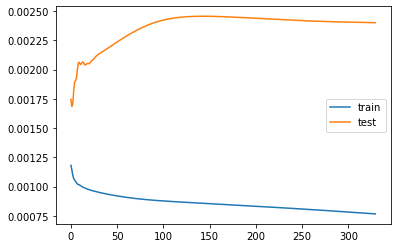

In [39]:
#Visual plot to check if the error is reducing
plt.plot(LSTMModel_fit.history['loss'], label='train')
plt.plot(LSTMModel_fit.history['val_loss'], label='test')
plt.legend()
plt.show()

In [40]:
error_Training_LSTM = mean_squared_error(y_train_LSTM, LSTMModel.predict(X_train_LSTM))
predicted = LSTMModel.predict(X_test_LSTM)
error_Test_LSTM = mean_squared_error(y_test,predicted)

2/2 [==============================] - 0s 2ms/step


In [41]:
# append to previous results
test_results.append(error_Test_ARIMA)
test_results.append(error_Test_LSTM)

train_results.append(error_Training_ARIMA)
train_results.append(error_Training_LSTM)

names.append("ARIMA")
names.append("LSTM")

## Overall comparison

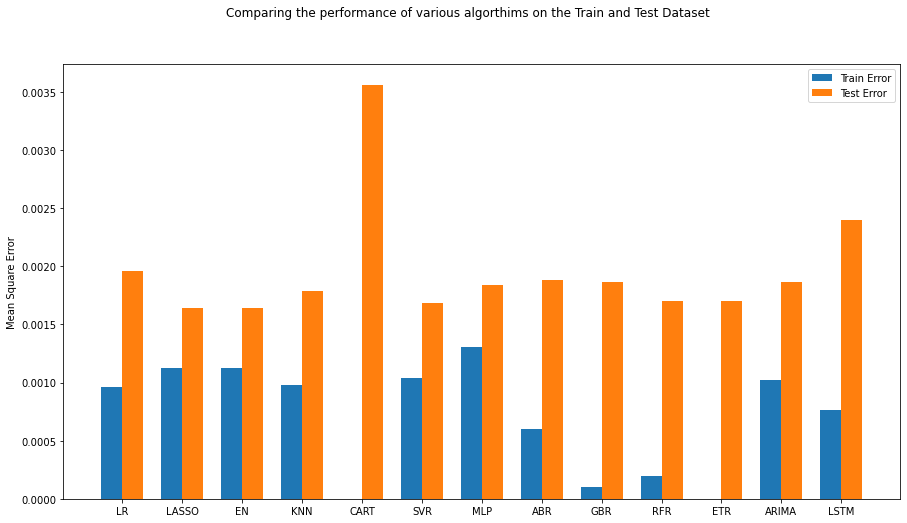

In [42]:
# compare algorithms
fig = plt.figure()

ind = np.arange(len(names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Comparing the performance of various algorthims on the Train and Test Dataset')
ax = fig.add_subplot(111)
plt.bar(ind - width/2, train_results,  width=width, label='Train Error')
plt.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
plt.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
plt.ylabel('Mean Square Error')
plt.show()